Time-Series Prediction
Time series and sequence prediction could be a really amazing to predict/estimate a robot's trajectory which requires temporal data at hand. In this assignemnt we will see how this could be done using Deep Learning.

Given a dataset [link](https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv) for airline passengers prediction problem. Predict the number of international airline passengers in units of 1,000 given a year and a month.
Here is how the data looks like.

In [46]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import math
import torch
import torchvision
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim

from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

file_link = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv' # dataset path
# Reading data using pandas or csv
df = pd.read_csv(file_link)

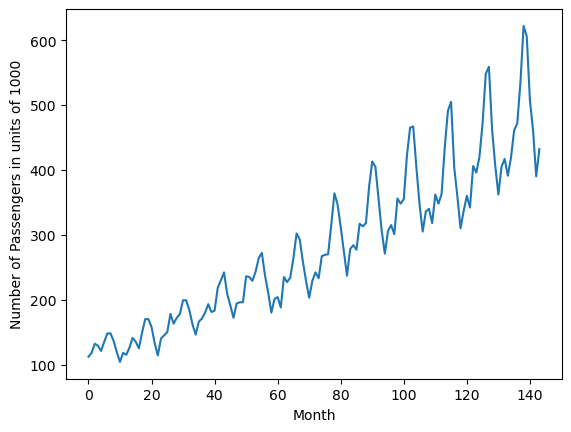

In [47]:
# Reading the dataset
training_set = df.iloc[:,1:2].values
# Plotting the dataset
plt.plot(training_set)
plt.ylabel('Number of Passengers in units of 1000')
plt.xlabel('Month')
plt.show()

1. Write the dataloader code to pre-process the data for pytorch tensors using any library of your choice. Here is a good resource for the dataloader [Video link](https://www.youtube.com/watch?v=PXOzkkB5eH0)


In [48]:
# Write your code here for the dataloader in Pytorch
def data_transform(data, sequence_length):
    x , y = [] , []
    for i in range (len(data)-sequence_length-1):
        x_ = data[i:(i+sequence_length)]
        y_ = data[i+sequence_length]
        x.append(x_)
        y.append(y_)
        
    return np.array(x) , np.array(y)

scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_set)

sequence_length = 4
transformed_x , transformed_y = data_transform(training_data, sequence_length)

train_size = int(len(transformed_y) * 0.70)
test_size = len(transformed_y) - train_size

x = Variable(torch.Tensor(np.array(transformed_x)))
y = Variable(torch.Tensor(np.array(transformed_y)))

train_X = Variable(torch.Tensor(np.array(transformed_x[0:train_size])))
train_Y = Variable(torch.Tensor(np.array(transformed_y[0:train_size])))

test_X = Variable(torch.Tensor(np.array(transformed_x[train_size:len(transformed_x)])))
test_Y = Variable(torch.Tensor(np.array(transformed_y[train_size:len(transformed_y)])))

print(training_data.shape)
print(x.shape)
print(y.shape)

(144, 1)
torch.Size([139, 4, 1])
torch.Size([139, 1])


2. Create the model in pytorch here uinsg 1. Long-Short Term Memory (LSTM) and 2. Recurrent Neural Network (RNN). Here is a good resource for Custom model generation.

  Train using the two models. Here is the resource for the same [Video link](https://www.youtube.com/watch?v=VVDHU_TWwUg)

<b style='font-size:16px;'>a. LSTM</b>

In [49]:
# write your code here for the custom model creating for both the methods
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
        self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
        self.num_layers, x.size(0), self.hidden_size))
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)

        return out

In [50]:
# Initialize the training values
num_of_epochs = 2000
rate_of_learning = 0.01
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

lstm_model = LSTM(num_classes, input_size, hidden_size, num_layers)
loss_function = torch.nn.MSELoss()
optimize = torch.optim.Adam(lstm_model.parameters(), lr=rate_of_learning)

#Training model with loss function and optimizer
for epoch in range(num_of_epochs+1):
    outputs = lstm_model(train_X)
    optimize.zero_grad()
    loss = loss_function(outputs, train_Y)
    loss.backward()
    optimize.step()

    if epoch % 100 == 0:
        print("EPOCH: %d ==> Loss: %2f" % (epoch, loss.item()))


EPOCH: 0 ==> Loss: 0.086289
EPOCH: 100 ==> Loss: 0.003848
EPOCH: 200 ==> Loss: 0.002403
EPOCH: 300 ==> Loss: 0.002005
EPOCH: 400 ==> Loss: 0.001869
EPOCH: 500 ==> Loss: 0.001846
EPOCH: 600 ==> Loss: 0.001842
EPOCH: 700 ==> Loss: 0.001840
EPOCH: 800 ==> Loss: 0.001838
EPOCH: 900 ==> Loss: 0.001836
EPOCH: 1000 ==> Loss: 0.001833
EPOCH: 1100 ==> Loss: 0.001831
EPOCH: 1200 ==> Loss: 0.001828
EPOCH: 1300 ==> Loss: 0.001826
EPOCH: 1400 ==> Loss: 0.001823
EPOCH: 1500 ==> Loss: 0.001820
EPOCH: 1600 ==> Loss: 0.001816
EPOCH: 1700 ==> Loss: 0.001812
EPOCH: 1800 ==> Loss: 0.001808
EPOCH: 1900 ==> Loss: 0.001802
EPOCH: 2000 ==> Loss: 0.001797


<b style='font-size:16px;'>b. RNN</b>


In [51]:
class RNN(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length

        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        _, h_out = self.rnn(x, h_0)
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        
        return out

In [52]:
# Initialize the training values
num_of_epochs = 2000
rate_of_learning = 0.01
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1

rnn_model = RNN(num_classes, input_size, hidden_size, num_layers)
loss_function = torch.nn.MSELoss()
optimize = torch.optim.Adam(rnn_model.parameters(), lr=rate_of_learning)

#Training model with loss function and optimizer
for epoch in range(num_of_epochs+1):
    outputs = rnn_model(train_X)
    optimize.zero_grad()
    loss = loss_function(outputs, train_Y)
    loss.backward()
    optimize.step()

    if epoch % 100 == 0:
        print("EPOCH: %d ==> Loss: %2f" % (epoch, loss.item()))

EPOCH: 0 ==> Loss: 0.648336
EPOCH: 100 ==> Loss: 0.023470
EPOCH: 200 ==> Loss: 0.017690
EPOCH: 300 ==> Loss: 0.012431
EPOCH: 400 ==> Loss: 0.005655
EPOCH: 500 ==> Loss: 0.001994
EPOCH: 600 ==> Loss: 0.001967
EPOCH: 700 ==> Loss: 0.001945
EPOCH: 800 ==> Loss: 0.001928
EPOCH: 900 ==> Loss: 0.001914
EPOCH: 1000 ==> Loss: 0.001904
EPOCH: 1100 ==> Loss: 0.001897
EPOCH: 1200 ==> Loss: 0.001891
EPOCH: 1300 ==> Loss: 0.001888
EPOCH: 1400 ==> Loss: 0.001885
EPOCH: 1500 ==> Loss: 0.001882
EPOCH: 1600 ==> Loss: 0.001880
EPOCH: 1700 ==> Loss: 0.001878
EPOCH: 1800 ==> Loss: 0.001875
EPOCH: 1900 ==> Loss: 0.001873
EPOCH: 2000 ==> Loss: 0.001870


3. Evaluate and Compare the result using proper metric. Justify the metrics used.


<b style='font-size:20px;'>Evaluation</b>


In addressing regression challenges, it's crucial to utilize mean squared error (MSE) and R-squared (R2) as the primary metrics for evaluation.

MSE measures the average of the squares of the errors, essentially the difference between the actual and predicted values. A smaller MSE indicates superior model performance, reflecting closer predictions to the actual data.

Conversely, R2 evaluates how well the variations in the dependent variable are explained by the model. A higher R2 value, approaching 1.0, denotes that the model accurately represents the variance in the target variable, indicating a strong fit to the data.

Through the analysis of these particular metrics, we're able to determine the accuracy of the models in making predictions (shown by a lower MSE) and their congruence with the data patterns (evidenced by a higher R2). These metrics are essential for validating the models' ability to generalize to new, unseen data effectively.

In [53]:
lstm_prediction = lstm_model(test_X)
lstm_prediction = lstm_prediction.detach().numpy()

rnn_prediction = rnn_model(test_X)
rnn_prediction = rnn_prediction.detach().numpy().squeeze()

lstm_mse = mean_squared_error(test_Y, lstm_prediction)
lstm_r2 = r2_score(test_Y, lstm_prediction)
print("R2 Score and MSE Comparison:\n")
print("LSTM MSE     : ", lstm_mse)
print("LSTM R2      : ", lstm_r2)

rnn_mse = mean_squared_error(test_Y, rnn_prediction)
rnn_r2 = r2_score(test_Y, rnn_prediction)
print("\nRNN MSE : ", rnn_mse)
print("RNN R2  : ", rnn_r2)

R2 Score and MSE Comparison:

LSTM MSE     :  0.011697228
LSTM R2      :  0.47809733145099653

RNN MSE :  0.011112072
RNN R2  :  0.5042056404141515


In the cell above, we have done a comparison of the LSTM and RNN models with respect to their predictive performance and model fit.

The Mean Square Error for the LSTM model is 0.01169, whereas the RNN model returns a value of 0.0111. This shows that the RNN models exhibits slightly less error and is more accurate compared to that of the LSTM model in terms of true values.

The R2 values is used to test the model fit. In this case, the R2 values of the LSTM model is 0.4781, whereas the RNN model returns a value of 0.5042 which is slightly higher than that of LSTM. This shows the RNN model is better at capturing the underlying data's variance.

Overall, both models show relatively low error rates in predictions and account for a substantial amount of the data's variance, as demonstrated by their MSE and R2 scores. However, it is noted that the RNN model slightly performs better than the LSTM model in terms of metrics, suggesting that its prediction is a bit more precise and its alignment with data is slightly improved. Despite both exhibiting good performances, the RNN model seems to have a marginal edge in generalizing better to unseen data.

To sum up, the analysis presented indicates that the RNN model has a minor superiority over the LSTM model, shown by its lower MSE and higher R2 value on test data. However, it's crucial to highlight that both models shown commendable predictive accuracy and fit to data as per as regression metrics.


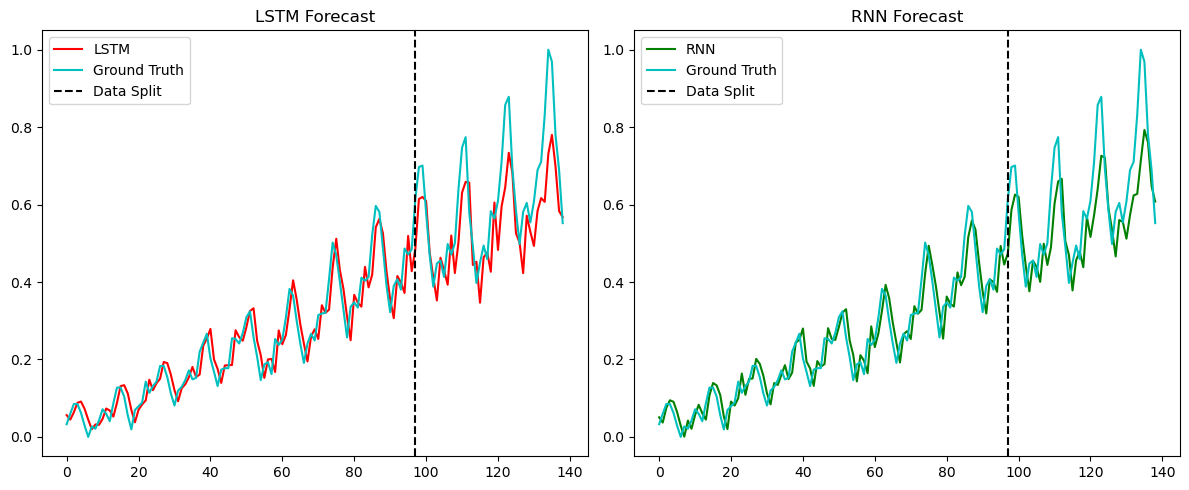

In [54]:
lstm_prediction_train = lstm_model(train_X)
lstm_prediction_train = lstm_prediction_train.detach().numpy()

rnn_prediction_train = rnn_model(train_X)
rnn_prediction_train = rnn_prediction_train.detach().numpy().squeeze()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([*lstm_prediction_train, *lstm_prediction], c='r', label='LSTM')
plt.plot([*train_Y, *test_Y], c='c', label='Ground Truth')
plt.axvline(x = len(train_Y), c='k',linestyle='dashed', label = 'Data Split')
plt.title("LSTM Forecast")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([*rnn_prediction_train, *rnn_prediction], c='g', label='RNN')
plt.plot([*train_Y, *test_Y], c='c', label='Ground Truth')
plt.axvline(x = len(train_Y), c='k',linestyle='dashed', label = 'Data Split')
plt.title("RNN Forecast")
plt.legend()

plt.tight_layout()
plt.show()

[Bonus 5 points] Suggest some things that could be done to improve the results.


1. Hyperparameter Tuning such as experimenting with different learning rates , batch sizes, number of epochs and incorporating other techniques such as grid or random search to find the best model hyperparameters.

2. Experimenting with the model architecture such as adding more layers in the LSTM or RNN models or using bidirectional LSTM to catch patterns from past and future situations. Additionally, experimenting with different loss function and optimizer will play a role in finding an enhanced result.

3. With the help of more complex datasets and using attention mechanisms with the models to focus on specific parts of the sequence of the input when making prediction will improve accuracy for longer sequences.

4. Improving accuracy by training multiple LTSM and RNN models with different architectures and hyperparameters and averaging their predictions.

[Bonus 5 points] Suggest where this could be used in Robotics other than the example given in the beginning.

1. Prediction in navigation and mapping of autonomous vehicles and drone to navigate in complex and unstructured environments by analyzing patterns in spatial-temporal data.
   
2. Understanding spoken commands involving analyzing audio signals as time-series data in application of interactive robots. This can help improve speech recognition which enables a natural communication between humans and robots.
   
3. Equipped vision systems in robots use time-prediction series to track moving objects over time which is crucial for surveillance, rescue mission and analytics.
   
4. Forecasting is another application where the future environmental state can be predicted on the basis of temporal perception data by these models.
   
5. By analysis of time-series data from sensor montoring, deep learning models can predict the failure or requirement of maintenance of any parts. This plays a crucial role in reducing downtime and extending lifespan of robots in manufacturing and logistics applications.